<a href="https://colab.research.google.com/github/Iamsdt/UdacityPyTorch/blob/master/src/notebook/final/Flower3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

import torch

In [2]:
# Load data
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json

!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip

!unzip -qq flower_data.zip

print("Data loaded")

Data loaded


Class Directory:  62


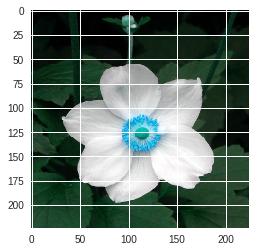

(224, 224, 3)


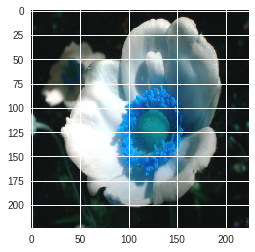

(224, 224, 3)


In [4]:
# view random image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import os

data_dir = "flower_data"
TRAIN_DATA_DIR = "{}/train".format(data_dir)
FILE_DIR = str(np.random.randint(1,103))
print("Class Directory: ",FILE_DIR)
for file_name in os.listdir(os.path.join(TRAIN_DATA_DIR, FILE_DIR))[1:3]:
    img_array = cv2.imread(os.path.join(TRAIN_DATA_DIR, FILE_DIR, file_name))
    img_array = cv2.resize(img_array,(224, 224), interpolation = cv2.INTER_CUBIC)
    plt.imshow(img_array)
    plt.show()
    print(img_array.shape)

In [19]:
# Load train class
!wget -c https://raw.githubusercontent.com/Iamsdt/UdacityPyTorch/master/src/notebook/Train.py

import Train

--2018-12-26 04:28:49--  https://raw.githubusercontent.com/Iamsdt/UdacityPyTorch/master/src/notebook/Train.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [20]:
# create train and test loader
data_dir = 'flower_data'

from torchvision import datasets, transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_valid = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# ceate data loader
train_loader, valid_loader, test_loader = Train.prepare_loader(data_dir,transform_train,transform_valid,test_transforms)

Train size:6552
Valid size:6552
Test size:818


In [21]:
from torchvision import models
# load a pretrained model
model = models.densenet121(pretrained = True)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [22]:
from collections import OrderedDict
from torch import nn

# create a simple classifier
classifier = nn.Sequential(OrderedDict([
                ('fc1', nn.Linear(1024, 500)),
                ('relu', nn.ReLU()),
                ('fc2', nn.Linear(500, 102)),
                ('output', nn.LogSoftmax(dim=1))
                ]))

# replace the classifer
model.classifier = classifier
# check the classifier
print(model.classifier)

Sequential(
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=102, bias=True)
  (output): LogSoftmax()
)


In [0]:
from torch import optim
from torch.optim import lr_scheduler
# set cretrion and optimizer
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

#move tensor to default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [1]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl


In [10]:
# Train the model
model, train_loss,valid_loss = Train.train_model(
    model,train_loader,valid_loader, 1, optimizer,scheduler, criterion)

Epoch: 1/1
		Going for validation
	Train loss:2.905599.. 	Valid Loss:0.968379.. 	Accuracy: 19.4656
	Validation loss decreased (inf --> 0.968379).  Saving model ...
	One epoch complete in 4m 11s
Training complete in 4m 11s


In [66]:
test_loss = 0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

with torch.no_grad():
  model.eval() # prep model for evaluation
  for data, target in test_loader:
      # Move input and label tensors to the default device
      data, target = data.to(device), target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the loss
      loss = criterion(output, target)
      # update test loss 
      test_loss += loss.item() #*data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)
      # compare predictions to true label
      correct = np.squeeze(pred.eq(target.data.view_as(pred)))
      # calculate test accuracy for each object class
      for i in range(16):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1
  
  # calculate and print avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))
  
  for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.233402

Test Accuracy of     0:  0% ( 0/ 8)
Test Accuracy of     1:  0% ( 0/ 4)
Test Accuracy of     2:  0% ( 0/ 5)
Test Accuracy of     3:  0% ( 0/ 2)
Test Accuracy of     4:  0% ( 0/ 6)
Test Accuracy of     5:  0% ( 0/ 8)
Test Accuracy of     6:  0% ( 0/ 4)
Test Accuracy of     7:  0% ( 0/ 4)
Test Accuracy of     8: N/A (no training examples)
Test Accuracy of     9:  0% ( 0/ 3)

Test Accuracy (Overall):  0% ( 5/656)


In [0]:
# calculate accuracy
import os
classes = os.listdir("{}/valid".format(data_dir))
dataiter = iter(test_loader)

images, labels = dataiter.next()
img = images.numpy()

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
for single_img in img:
    single_img = std * single_img + mean

#img = np.clip(single_img, 0, 1)

# move model inputs to cuda, if GPU available
images = images.to(device)

train_on_gpu  = torch.cuda.is_available()


#img = std * img + mean
#img = np.clip(img, 0, 1)



model.eval() # Required for Evaluation/Test
# get sample outputs
output = model(images)
if type(output) == tuple:
            output, _ = output
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20, 5))
for idx in np.arange(12):
    ax = fig.add_subplot(3, 4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title("Pr: {} Ac: {}".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [0]:
# calculate accuracy
# Test our Model Performance with Gabriele Picco's Program
!wget -c https://raw.githubusercontent.com/GabrielePicco/deep-learning-flower-identifier/master/test_model_pytorch_facebook_challenge.py

import test_model_pytorch_facebook_challenge as test

testset_path="{}/valid".format(data_dir)
v = test.calc_accuracy(model, input_image_size=224, testset_path=testset_path)
print("Mean accuracy: ",v)

In [0]:
# test accuracy with google data set
v = test.calc_accuracy(model, input_image_size=224,use_google_testset=True)
print("Mean accuracy: ",v)

In [0]:
# plost solution
# helper class
def process_image(image_path):
    """
    Scales, crops, and normalizes a PIL image for a PyTorch
    model, returns an Numpy array
    """
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop
    left_margin = (img.width - 224) / 2
    bottom_margin = (img.height - 224) / 2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,
                    top_margin))
    # Normalize
    img = np.array(img) / 255
    mean = np.array([0.485, 0.456, 0.406])  # provided mean
    std = np.array([0.229, 0.224, 0.225])  # provided std
    img = (img - mean) / std

    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))

    return img


def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax


# Class Prediction

def predict(image_path, model, top_num=5):
    """
    Predict the class of an image, given a model
    :param image_path:
    :param model:
    :param top_num:
    :return:
    """
    # Process image
    img = process_image(image_path)

    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)

    image_tensor.to('cpu')
    model_input.to('cpu')
    model.to('cpu')

    # Probs
    probs = torch.exp(model.forward(model_input))

    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0]
    top_labs = top_labs.detach().numpy().tolist()[0]

    # Convert indices to classes
    idx_to_class = {val: key for key, val in
                    model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers

In [0]:
# Sanity Checking
def plot_solution(image_path, model):
    """
    Plot an image with the top 5 class prediction
    :param image_path:
    :param model:
    :return:
    """
    # Set up plot
    plt.figure(figsize=(6, 10))
    ax = plt.subplot(2, 1, 1)
    # Set up title
    flower_num = image_path.split('/')[3]
    title_ = cat_to_name[flower_num]
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title=title_);
    # Make prediction
    probs, labs, flowers = predict(image_path, model)
    # Plot bar chart
    plt.subplot(2, 1, 2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

In [0]:
# visualize the solution
valid_dir = "{}/valid".format(data_dir)
image_path = os.path.join(valid_dir, '28/image_05265.jpg')
plot_solution(image_path, model)